MainProcess
MainProcess


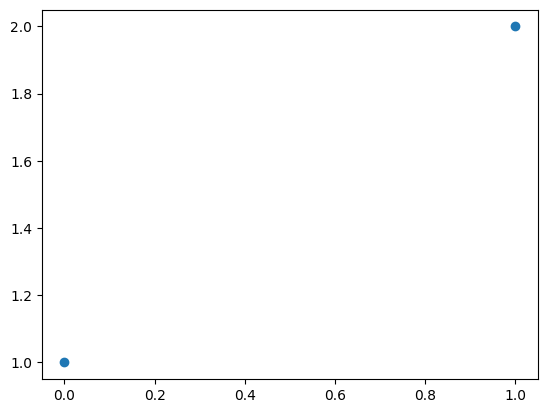

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
importlib.reload(fls);
fls.profiling=False
plt.scatter([0,1],[1,2])

In [2]:
files = glob.glob(fls.result_dir + '/many_abbr_full/Baseline_0M*')
models = [fls.dill_load(f) for f in files]
models = sorted(models, key=lambda d:d.trained_model.seed)

In [3]:
todo = slice(None)
data = copy.deepcopy(models[0].inferred_test_data[todo])

In [4]:
# for m in models[0:1]:
#     m.trained_model.step1Labels.relative_confidence_threshold = 0.001
#     m.inferred_test_data = m.trained_model.infer(m.test_data)

In [5]:
models[0].trained_model.step1Labels.seed

0

In [6]:
highest_false_score = []
real_score = []
data_list = []
for i_type in range(3):
    model = copy.deepcopy(models[0].untrained_model)
    model.step1Labels.relative_confidence_threshold = 0.01
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    if i_type == 0:
        # baseline
        pass
    elif i_type==1:
        # blur
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
    elif i_type==2:
        # no resize
        model.step1Labels.preprocessor = flg_preprocess.Preprocessor2()
        model.step1Labels.preprocessor.target_voxel_spacing = 20.
        model.step1Labels.box_size = 18
        model.step1Labels.prevent_ultralytics_resize = True
    model.run_in_parallel = False   
    model_file = fls.temp_dir + 'model_' + str(i_type) + '.pickle'
    if not os.path.isfile(model_file):
        model.train(models[0].train_data, models[0].test_data)
        fls.dill_save(model_file, model)
    model = fls.dill_load(model_file)
    #model = fls.dill_load(fls.temp_dir + 'model_' + str(i_type) + '.pickle')
    data_file = fls.temp_dir + 'data_' + str(i_type) + '.pickle'
    if not os.path.isfile(data_file):
        inferred_data = model.infer(models[0].test_data[todo])
        fls.dill_save(data_file, inferred_data)
    inferred_data = fls.dill_load(data_file)    
    for d in inferred_data:
        d.labels_unfiltered = d.labels_unfiltered2
    fls.mark_tf_pn(inferred_data, models[0].test_data[todo])
    data_list.append(inferred_data)
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, models[0].test_data[todo]):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)


In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [8]:
for d in data_list:
    n_corr=0
    n_total=0
    for i,r in zip(d, models[0].test_data[todo]):
        if len(r.labels)>0:
            n_total+=1
            ind = np.argmax(i.labels_unfiltered['confidence'])
            if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                n_corr += 1
    print(n_corr/n_total)
    #print(i.labels_unfiltered)

0.705
0.765
0.95


In [9]:
i_baseline = 1; i_new = 2;

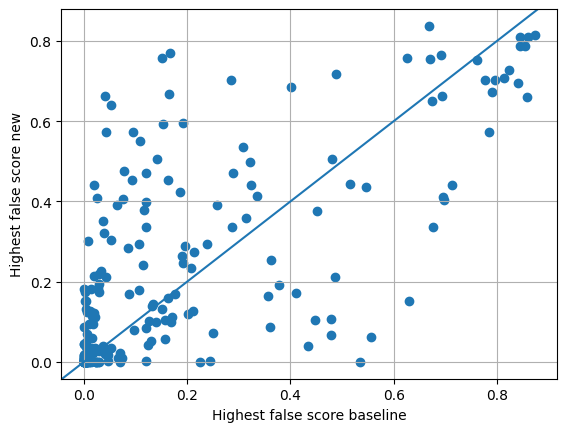

In [10]:
plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
plt.xlabel('Highest false score baseline')
plt.ylabel('Highest false score new')
plt.grid(True)
plt.axline((0,0),slope=1)

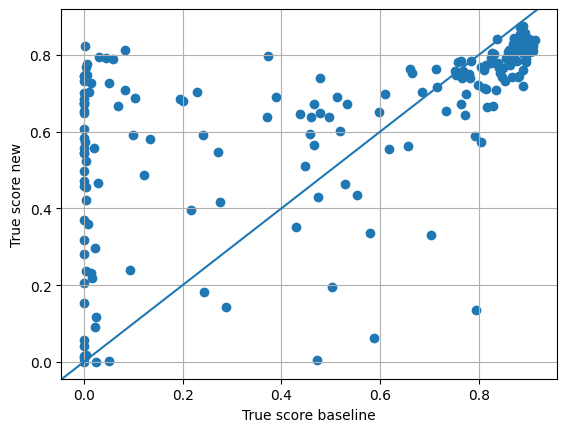

In [11]:
plt.scatter(real_score[i_baseline], real_score[i_new])
plt.xlabel('True score baseline')
plt.ylabel('True score new')
plt.grid(True)
plt.axline((0,0),slope=1)

In [12]:
xx=(np.argwhere(np.logical_and(np.array(real_score[i_baseline])>0.6, np.array(real_score[i_new])<0.1))).flatten()
xx

array([], dtype=int64)

In [13]:
#cur_id = 87
cur_id = 0
for ii in range(len(models[0].test_data[todo])):
    if len(models[0].test_data[todo][ii].labels)>0:     
        if cur_id in xx:
            print(models[0].test_data[todo][ii].name,ii,real_score[i_baseline][cur_id],real_score[i_new][cur_id])
        cur_id+=1

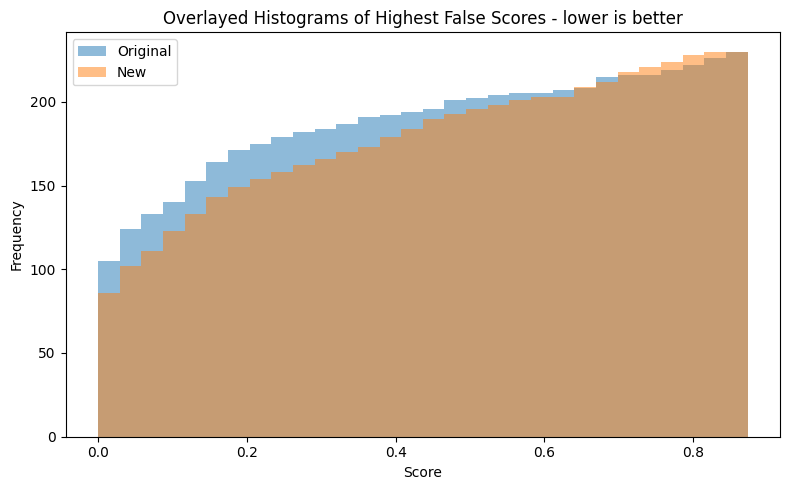

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([highest_false_score[i_baseline], highest_false_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(highest_false_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(highest_false_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of Highest False Scores - lower is better')
plt.legend()
plt.tight_layout()
plt.show()

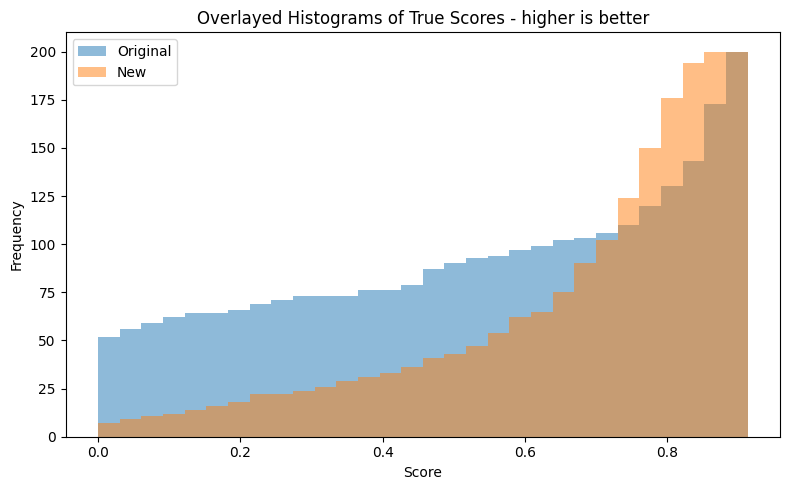

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([real_score[i_baseline], real_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(real_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(real_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of True Scores - higher is better')
plt.legend()
plt.tight_layout()
plt.show()